In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import scanpy as sc
import mojitoo  
import numpy as np

# Import the evaluation utilities
from utils.eval_utils import (
    compute_ari_nmi,
    compute_silhouette,
    compute_structure_preservation
)

In [22]:
adt_data = sc.read_h5ad("./../datasets/data/processed/PBMC-DOGMA_adt.h5ad")
rna_data = sc.read_h5ad("./../datasets/data/processed/PBMC-DOGMA_RNA.h5ad")
atac_data = sc.read_h5ad("./../datasets/data/processed/PBMC-DOGMA_atac.h5ad")

In [23]:
if "X_pca" not in rna_data.obsm:
    sc.tl.pca(rna_data, svd_solver='arpack')

# For ADT (protein/epitope data)
if "X_pca" not in adt_data.obsm:  # assuming ADT PCA is stored as "X_pca"
    sc.tl.pca(adt_data, n_comps=30)  # often 30 PCs are used for ADT

# For ATAC, assume LSI is already computed and stored in "X_lsi"
# Remove the first component to get a refined LSI representation:
atac_data.obsm["lsi"] = atac_data.obsm["X_lsi"][:, 1:]

adata = rna_data.copy()
adata.obsm["pca"] = rna_data.obsm["X_pca"]      # RNA modality
adata.obsm["apca"] = adt_data.obsm["X_pca"]       # ADT modality (PCA reduction)
adata.obsm["lsi"] = atac_data.obsm["lsi"]        # ATAC modality (LSI reduction)

mojitoo.mojitoo(
    adata,
    reduction_list=["pca", "lsi", "apca"],
    dims_list=(
        range(adata.obsm["pca"].shape[1]),
        range(adata.obsm["lsi"].shape[1]),
        range(adata.obsm["apca"].shape[1])
    ),
    reduction_name='mojitoo',
    overwrite=True
)

1 round cc 48
2 round cc 30


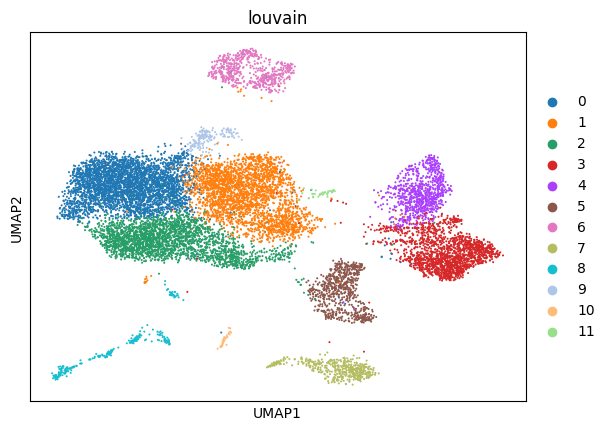

In [24]:
sc.pp.neighbors(adata, use_rep='mojitoo')
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color='louvain')

In [25]:

# 4) Evaluate ARI and NMI
ari, nmi = compute_ari_nmi(
    adata=adata,
    cluster_key="louvain",
    truth_key="celltype"  
)
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

# ARI should be between 0.5 to 0.9 depending on the dataset and number of cell types (above 0.7 means good clustering)
# NMI typically between 0.5-0.8

Adjusted Rand Index: 0.472
Normalized Mutual Information: 0.558


In [26]:
# 5) Evaluate Silhouette Score
sil_score = compute_silhouette(
    adata=adata,
    embedding_key="mojitoo",
    cluster_key="louvain"
)
print(f"Silhouette Score: {sil_score:.3f}")

# ranges from -1 (worst) to +1 (best) 0.2-0.6 common for scRNA-seq

# # 6) Evaluate Structure Preservation
# structure_corr = compute_structure_preservation(
#     adata=protein_data,
#     integrated_key="mojitoo",
#     original_keys=["pca", "apca"]
# )
# print("Structure Preservation Correlations:")
# for k, (r, p) in structure_corr.items():
#     print(f" - {k}: r={r:.3f}, p={p:.1e}")

# for MOJITOO should be 0.5-0.8

Silhouette Score: 0.065
